# Comparison of 1-step and Multi-step to Analytic Score

In this notebook we compare the learned score with the analytic score of an affine SDE that is similar to SDEs considered for score-based generative modelling.

## Physical System SDE

As physical system, we consider the following SDE defined by 

$$dx = - \lambda x dt + g dW$$

with $\lambda = 1$ and $g = 0.03$.

Paths of this SDE will start in either $-1$ or $1$ at $t=0$ and approach $0$ as $t$ increases. Because this SDE is affine, we can easily derive the analytic score field. 

In [1]:
g = 0.04
lambda_ = 0.5
physics_operator = lambda x: - x * lambda_

We use diffrax to solve the SDE with Euler steps

In [2]:
from diffrax import VirtualBrownianTree, MultiTerm, ODETerm, WeaklyDiagonalControlTerm, Euler, SaveAt, diffeqsolve

def r_process(initial_value, noise_scaling, seed):

    initial_shape = (1,)
    y0 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    drift = lambda t, y, args: physics_operator(y)

    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=initial_shape, key=jr.PRNGKey(seed))
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(dense=True)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=0.01, y0=y0, saveat=saveat)
    
    return sol

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/custom_types.py:133: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(0))
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/solver/runge_kutta.py:116: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  term_structure = jax.tree_structure(0)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/solver/euler.py:25: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  term_structure = jax.tree_structure(0)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/solver/euler_heun.py:23: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_

## Visualization of SDE paths
We first set a *seed* for the SDE paths

In [3]:
seed = 2023

Next, we define some options for plotting

In [4]:
import seaborn as sns

sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})
sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white', 'axes.labelcolor' : "black", 'text.color' : "black"})

Now, we plot paths from for the SDE 

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/integrate.py:617: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  term_leaves, term_structure = jax.tree_flatten(
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:21: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:27: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Us

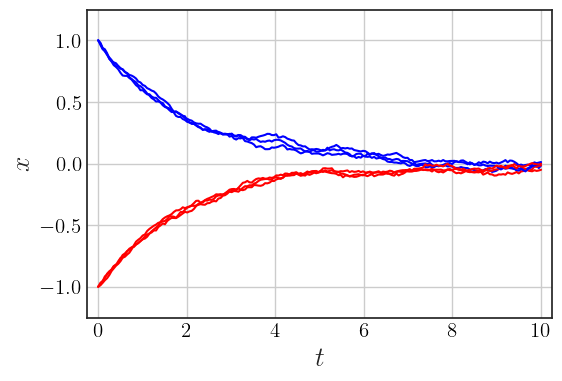

In [5]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
import jax.random as jr

with plt.style.context("seaborn-white"):

    # paths starting in 1.0
    value_one = [r_process(1.0, g, seed+n) for n in range(0, 3)]
    
    # paths starting in -1.0
    value_minus_one = [r_process(-1.0, g, seed+n) for n in range(3, 6)]

    fig, ax = plt.subplots(figsize=(6,4))

    x = jnp.linspace(0,10,200)
    
    for i in range(3):
    
        sol = value_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='blue')

        sol = value_minus_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='red')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'$t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([-0.25, 10.25])
    plt.ylim([-1.25,1.25])

    plt.show()

### Analytic Score
Conditioned on a starting point $x_0$, we can write the conditional distribution at time $t$ as a Gaussian with mean 
$$\mu(t) = x_0 e^{-\lambda t}$$
The variance of the Gaussian at time $t$ is given by
$$\sigma^2(t) = \frac{g^2}{2\lambda} (1-e^{-2\lambda t}).$$

In [6]:
def mean(t, x0, lambda_, g):
    
    return x0 * jnp.exp(-lambda_ * t)

def variance(t, x0, lambda_, g):
    
    return (g ** 2) / (2 * lambda_) * (1 - jnp.exp(-2 * lambda_ * t))

def density_gaussian(x, t, x0, lambda_, g):
    
    return 1 / jnp.sqrt(2 * jnp.pi * variance(t, x0, lambda_, g)) * jnp.exp(- (x - mean(t, x0, lambda_, g)) ** 2 / (2 * variance(t, x0, lambda_, g)))

def score_gaussian(x, t, x0, lambda_, g):
    
    return (x - mean(t, x0, lambda_, g)) / variance(t, x0, lambda_, g)  

#### Density field of paths
We first plot the density of paths on a grid $[0,10] \times [-1,1]$.

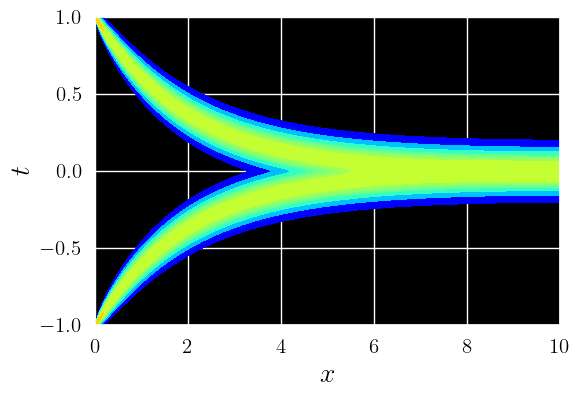

In [7]:
f_density_gaussian = lambda x, t: density_gaussian(x, t, 1.0, lambda_, g)
f_score_gaussian = lambda x, t: score_gaussian(x, t, 1.0, lambda_, g)   

x = jnp.linspace(-1,1,1000)
t = jnp.linspace(0,10,1000)

X, T = jnp.meshgrid(x, t)

Z = f_density_gaussian(X, T)    

fig, ax = plt.subplots(figsize=(6,4))   

im = ax.contourf(T, X, jnp.log((Z + jnp.flip(Z, axis=1))*0.5), cmap='jet', levels = [-10, -5, -2.5, -1, -0.5, 0, 0.5, 1, 2.5, 5, 10])  

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')    
ax.set_xlabel(r'$x$', size = 20)
ax.set_ylabel(r'$t$', size = 20)    
ax.grid(True)
ax.tick_params(labelsize=15)


#### Score of distribution conditioned on paths starting at -1

/tmp/ipykernel_1410044/1849626504.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


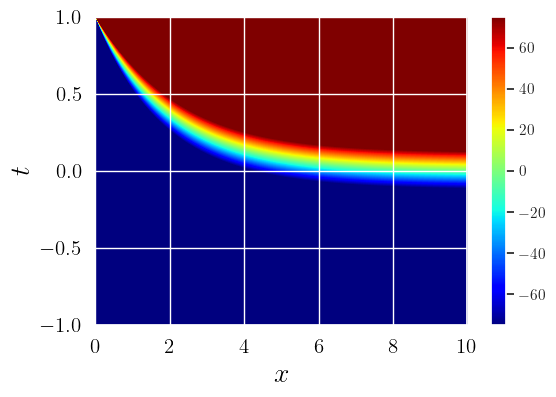

In [8]:
Z_score = f_score_gaussian(X, T)    

fig, ax = plt.subplots(figsize=(6,4))   

im = plt.imshow(Z_score.T, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')    
ax.set_xlabel(r'$x$', size = 20)
ax.set_ylabel(r'$t$', size = 20)    
ax.grid(True)
ax.tick_params(labelsize=15)

plt.colorbar(im)
plt.show()

#### Combine scores of paths starting in both -1 and 1

/tmp/ipykernel_1410044/3420422218.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


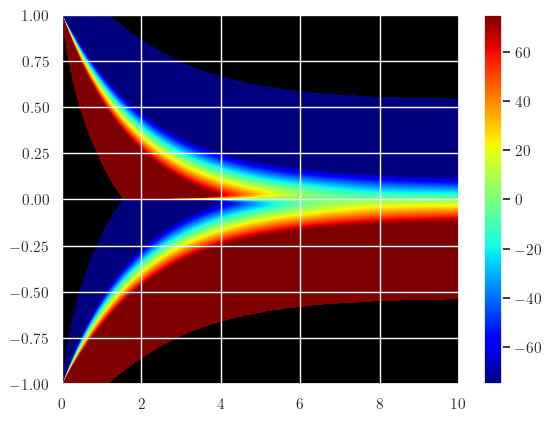

In [9]:
Z_sum = 1 / (Z + jnp.flip(Z, axis=1))

Z_score_joint = Z_sum * Z * Z_score - Z_sum * jnp.flip(Z, axis=1) * jnp.flip(Z_score, axis=1)

im = plt.imshow(-Z_score_joint.T, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')    
ax.set_xlabel(r'$x$', size = 20)
ax.set_ylabel(r'$t$', size = 20)    
ax.grid(True)
ax.tick_params(labelsize=15)

plt.colorbar(im)
plt.show()

Check that this indeed matches the gradient of the density using jnp.gradient

/tmp/ipykernel_1259322/3793843435.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


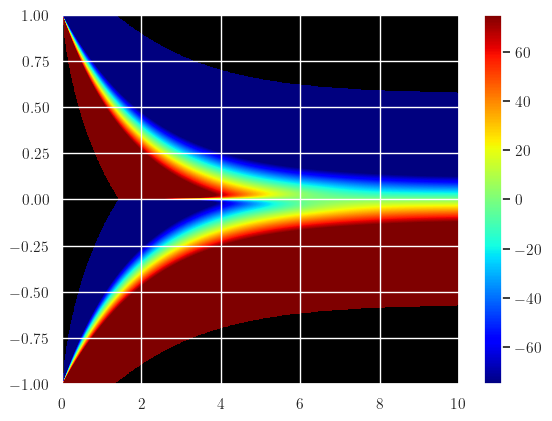

In [11]:
im = plt.imshow(500*jnp.gradient(jnp.log((Z + jnp.flip(Z, axis=1))*0.5))[1].T, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')    
ax.set_xlabel(r'$x$', size = 20)
ax.set_ylabel(r'$t$', size = 20)    
ax.grid(True)
ax.tick_params(labelsize=15)

plt.colorbar(im)
plt.show()


### Learned scores with 1-step and multi-step
First, we create the models and load the model weights

In [12]:
import sys
sys.path.append('github/smdp/toy_example')
from models.models import get_model, modelType
import jax.nn

model_type = modelType.mlp

model_config = {
            'output_sizes': [30, 30, 25, 20, 10, 1],
            'log_t': True,
            'activation': jax.nn.elu,
        }

key = jr.PRNGKey(0)

model = get_model(model_type, key, **model_config)

The trained model weights are stored at 

In [13]:
one_step_weight_path = 'github/smdp/toy_example/results/6G9PZOW1/model_params_5250000.pkl'
multi_step_weight_path = 'github/smdp/toy_example/results/3e48a37m/model_params_5020000.pkl'

In [14]:
import pickle
# load parameters
with open(one_step_weight_path, 'rb') as file:
    model_weights_1_step = pickle.load(file)
    
with open(multi_step_weight_path, 'rb') as file:
    model_weights_m_step = pickle.load(file)

Create grid used to plot the learned score

In [15]:
import numpy as np
import math

x_ = np.linspace(0., 10., 400)
y_ = np.linspace(-1, 1, 200)

X, Y = np.meshgrid(x_,y_)
full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
meshgrid = (X,Y)

Define functions to plot learned scores

In [16]:
from scipy.interpolate import griddata

dpi = 200
height = 6
width = 4 
scaling_factor = 1.

rng = jr.PRNGKey(0)

def _prepare_batch_grid(batch):
    
    inputs = [np.split(x, x.shape[1], 1) for x in batch]

    return inputs

def iterbatches_grid(X, batch_size, shuffle=False):

    def iterate(X, batch_size, shuffle=False):
        n_samples = X.shape[0]
        
        sample_perm = np.arange(n_samples)
        if batch_size is None:
            batch_size = n_samples
        if shuffle:
            sample_perm = np.random.permutation(n_samples)
        batch_idx = 0
        num_batches = math.ceil(n_samples / batch_size)
        while batch_idx < num_batches:
            start = batch_idx * batch_size
            end = min(n_samples, (batch_idx + 1) * batch_size)
            indices = range(start, end)
          
            perm_indices = sample_perm[indices]
            X_batch = X[perm_indices]
          
            batch_idx += 1
            yield ([X_batch])

    return iterate(X, batch_size, shuffle)

def create_eval_fn(forward_fn, params):
    """
    Evaluate model
    """
    @jax.jit
    def eval_model(t, x, rng=None):
       
        res = forward_fn(params, rng, x, t)
        return res
    return eval_model

def save_snapshot_score(params, forward_fn, meshgrid, step=None, savename=None):
    eval_fn = create_eval_fn(forward_fn, params)
    
    results = None
    
    X, Y = meshgrid
    full_domain = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    
    full_domain_scaled = full_domain * scaling_factor
    
    generator = iterbatches_grid(full_domain_scaled, 1000, shuffle=False)
    for batch in generator:
        inputs = _prepare_batch_grid(batch)
        
        output_values = eval_fn(*inputs[0], rng)
        if isinstance(output_values, jnp.ndarray):
            output_values = [output_values]
        output_values = [jax.device_get(t) for t in output_values]

        if results is None:
            results = [[] for i in range(len(output_values))]
        for i, t in enumerate(output_values):
            results[i].append(t)

    final_results = []
    if results is not None:
        for r in results:
            final_results.append(np.concatenate(r, axis=0))
    
    x_scaled = x_ * scaling_factor
    y_scaled = y_ * scaling_factor
    meshgrid_scaled = (meshgrid[0] * scaling_factor, meshgrid[1] * scaling_factor)  

    u_pred = final_results[0][:].flatten()
    U_pred = griddata(full_domain_scaled, u_pred.flatten(), meshgrid_scaled, method='cubic')
   
    return jnp.flip(U_pred / (g**2), axis=0)

Infer learned score fields

In [17]:
score_field_single_step = save_snapshot_score(model_weights_1_step, model[0], meshgrid)
score_field_multi_step = save_snapshot_score(model_weights_m_step, model[0], meshgrid)

### 1-step learned score
Plot the 1-step learned score

/tmp/ipykernel_1259322/3122830422.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


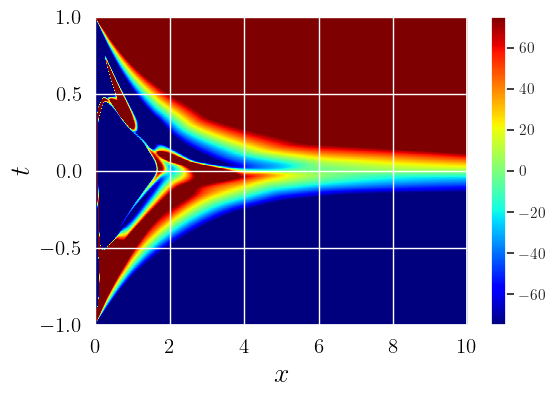

In [18]:
fig, ax = plt.subplots(figsize=(6,4))   

im = ax.imshow(score_field_single_step, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')    
ax.set_xlabel(r'$x$', size = 20)
ax.set_ylabel(r'$t$', size = 20)    
ax.grid(True)
ax.tick_params(labelsize=15)

plt.colorbar(im)
plt.show()

### Alpha mask to mask out regions with very low density in learned score
In our comparison, we want to mask out regions with very low density, since there is no learning signal in those ares and the values there are therefore not constrained in any way by the data and the network can take any values it wants.

/tmp/ipykernel_1259322/2495644463.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


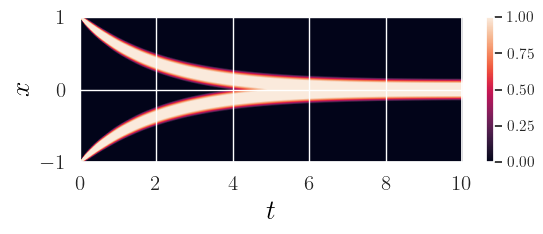

In [31]:
t = jnp.linspace(-1,1,200)
x = jnp.linspace(0,10,400)

X, T = jnp.meshgrid(t, x)

Z = f_density_gaussian(X, T)   
Z_score = f_score_gaussian(X, T)    
Z_sum = 1 / (Z + jnp.flip(Z, axis=1))

Z_score_joint = Z_sum * Z * Z_score - Z_sum * jnp.flip(Z, axis=1) * jnp.flip(Z_score, axis=1)


alpha = jnp.minimum(jnp.maximum(jnp.log((Z + jnp.flip(Z, axis=1))*0.5).T / 5 + 1,0), 1.0)
alpha = jnp.nan_to_num(alpha)

fig, ax = plt.subplots(figsize=(6,2.5))

im = ax.imshow(alpha, extent=[0,10,-1,1], aspect='auto', origin='lower')

ax.set_xlabel(r'$t$', size = 20)
ax.set_ylabel(r'$x$', size = 20)    
ax.grid(True)
ax.tick_params(labelsize=15)

plt.colorbar(im) 
plt.tight_layout()
plt.show()

### Comparison of analytic score and 1-step learned score 

/tmp/ipykernel_1259322/4105112980.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cbar_ax, label=r'Score $\nabla_x \log p_t(x)$')


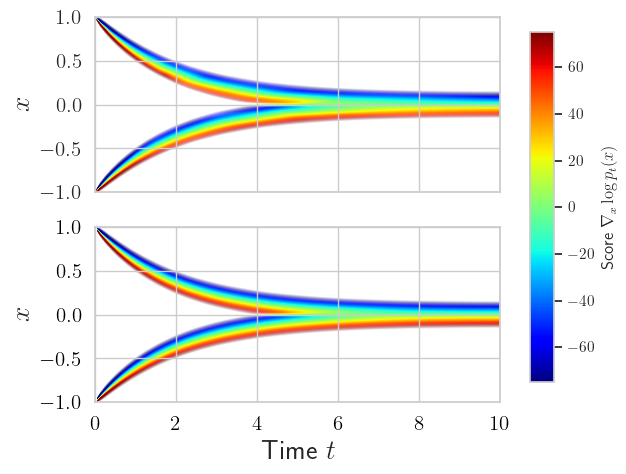

In [104]:
fig, axes = plt.subplots(nrows=2, figsize=(6,5))   

# score_field_single_step = jnp.where(alpha < 1e-5, jnp.nan, score_field_single_step)

im = axes[0].imshow(-score_field_single_step, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)
im = axes[1].imshow(-Z_score_joint.T, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)

axes[0].tick_params(axis='x', colors='black')

# remove xaxis ticks
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[0].set_ylabel(r'$x$', size = 20)    
axes[0].grid(True)
axes[0].tick_params(labelsize=15)

axes[1].tick_params(axis='x', colors='black')
axes[1].tick_params(axis='y', colors='black')    
axes[1].set_xlabel(r'Time $t$', size = 20)
axes[1].set_ylabel(r'$x$', size = 20)    
axes[1].grid(True)
axes[1].tick_params(labelsize=15)

# colorbar for both axes
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.04, 0.7])

fig.colorbar(im, cax=cbar_ax, label=r'Score $\nabla_x \log p_t(x)$') 

# save figure
plt.savefig('github/smdp/toy-example/notebooks/pictures/affine_1_step_comparison_score.svg', bbox_inches='tight')    

plt.show()

### Comparison: Analytic score, 1-step learned score, multi-step learned score

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/integrate.py:617: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  term_leaves, term_structure = jax.tree_flatten(
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:21: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:27: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Us

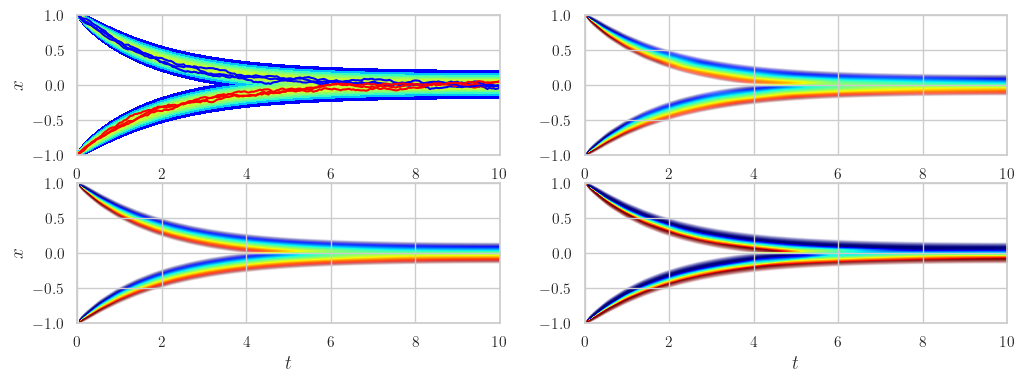

In [99]:
fig, axes = plt.subplots(2,2, figsize=(12,4))

seed = 0

im = axes[0][0].contourf(T, X, jnp.log((Z + jnp.flip(Z, axis=1))*0.5), cmap='jet', levels = [-10, -5, -2.5, -1, -0.5, 0, 0.5, 1, 2.5, 5, 10]) 

# paths starting in 1.0
value_one = [r_process(1.0, g, seed+n) for n in range(0, 3)]

# paths starting in -1.0
value_minus_one = [r_process(-1.0, g, seed+n) for n in range(3, 6)]

x = jnp.linspace(0,10,200)

for i in range(3):
    
    sol = value_one[i]
    axes[0][0].plot(x, jnp.diag(sol.evaluate(x)), color='blue')
    
    sol = value_minus_one[i]
    axes[0][0].plot(x, jnp.diag(sol.evaluate(x)), color='red')

axes[0][0].set_ylabel(r'$x$', size = 14)

im = axes[1][0].imshow(-Z_score_joint.T, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)

im = axes[0][1].imshow(-score_field_single_step, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)

axes[1][0].set_ylabel(r'$x$', size = 14)
axes[1][0].set_xlabel(r'$t$', size = 14)

im = axes[1][1].imshow(-score_field_multi_step, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)

axes[1][1].set_xlabel(r'$t$', size = 14)

plt.show()



### Density + paths

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/integrate.py:617: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  term_leaves, term_structure = jax.tree_flatten(
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:21: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:27: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Us

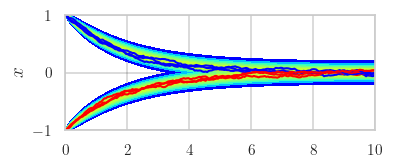

In [100]:
fig, ax = plt.subplots(1,1, figsize=(4,1.5))

seed = 0

x = jnp.linspace(-1,1,1000)
t = jnp.linspace(0,10,1000)

X, T = jnp.meshgrid(x, t)

Z = f_density_gaussian(X, T)    

im = ax.contourf(T, X, jnp.log((Z + jnp.flip(Z, axis=1))*0.5), cmap='jet', levels = [-10, -5, -2.5, -1, -0.5, 0, 0.5, 1, 2.5, 5, 10]) 

# paths starting in 1.0
value_one = [r_process(1.0, g, seed+n) for n in range(0, 3)]

# paths starting in -1.0
value_minus_one = [r_process(-1.0, g, seed+n) for n in range(3, 6)]

x = jnp.linspace(0,10,200)

for i in range(3):
    
    sol = value_one[i]
    ax.plot(x, jnp.diag(sol.evaluate(x)), color='blue')
    
    sol = value_minus_one[i]
    ax.plot(x, jnp.diag(sol.evaluate(x)), color='red')
    
# subplot title
# axes[0][0].set_title('Paths and density contour', size = 12)

ax.set_ylabel(r'$x$', size = 14)
ax.grid(linestyle='-', linewidth='0.2', color='black')
# save figure 
plt.savefig('github/smdp/toy-example/notebooks/pictures/toy_example_affine_paths.pdf', bbox_inches='tight')


### Analytic score

/tmp/ipykernel_1259322/3205363086.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


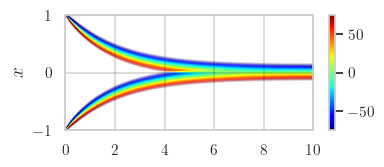

In [101]:
fig, ax = plt.subplots(1,1, figsize=(4,1.5))

im = ax.imshow(-Z_score_joint.T, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)
plt.colorbar(im)
ax.grid(linestyle='-', linewidth='0.2', color='black')
ax.set_ylabel(r'$x$', size = 14)
# save figure 
plt.savefig('github/smdp/toy-example/notebooks/pictures/toy_example_affine_analytic.pdf', bbox_inches='tight')

### Learned 1-step score

/tmp/ipykernel_1259322/184693010.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


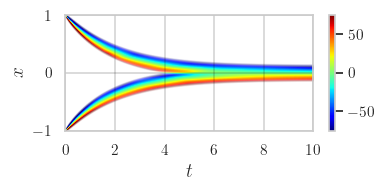

In [102]:
fig, ax = plt.subplots(1,1, figsize=(4,1.5))

im = ax.imshow(-score_field_single_step, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)

ax.set_ylabel(r'$x$', size = 14)
ax.set_xlabel(r'$t$', size = 14)
plt.colorbar(im)
ax.grid(linestyle='-', linewidth='0.2', color='black')
# save figure 
plt.savefig('github/smdp/toy-example/notebooks/pictures/toy_example_affine_1_step.pdf', bbox_inches='tight')

### Learned multi-step score 

/tmp/ipykernel_1259322/4123856003.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


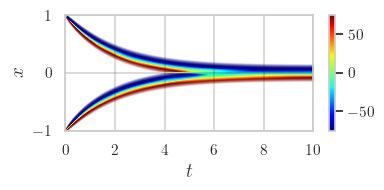

In [103]:
fig, ax = plt.subplots(1,1, figsize=(4,1.5))

im = ax.imshow(-score_field_multi_step, cmap='jet', vmin=-75, vmax=75, extent=[0,10,-1,1], aspect='auto', origin='lower', alpha=alpha)

ax.set_xlabel(r'$t$', size = 14)
ax.set_ylabel(r'$x$', size = 14)
plt.colorbar(im)
ax.grid(linestyle='-', linewidth='0.2', color='black')

# save figure 
plt.savefig('github/smdp/toy-example/notebooks/pictures/toy_example_affine_m_step.pdf', bbox_inches='tight')

## Plots for Paths, Probability Flow ODE and Reverse-time SDE
### 1. Plots for paths

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/integrate.py:617: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  term_leaves, term_structure = jax.tree_flatten(
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:21: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/heuristics.py:27: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, _ = jax.tree_flatten(terms, is_leaf=is_brownian)
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Us

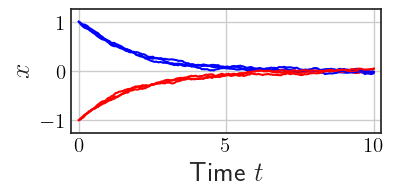

In [109]:
with plt.style.context("seaborn-white"):

    # paths starting in 1.0
    value_one = [r_process(1.0, g, seed+n) for n in range(0, 3)]
    
    # paths starting in -1.0
    value_minus_one = [r_process(-1.0, g, seed+n) for n in range(3, 6)]

    fig, ax = plt.subplots(figsize=(4, 1.6))

    x = jnp.linspace(0,10,200)
    
    for i in range(3):
    
        sol = value_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='blue')

        sol = value_minus_one[i]
        ax.plot(x, jnp.diag(sol.evaluate(x)), color='red')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'Time $t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([-0.25, 10.25])
    plt.ylim([-1.25,1.25])

    plt.savefig('github/smdp/toy-example/notebooks/pictures/affine_data.svg', bbox_inches='tight')

    plt.show()

### 2. Reverse-time SDE

In [110]:
forward_fn = model[0]

def r_process_reverse(initial_value, params, noise_scaling, seed):
    key = jr.PRNGKey(seed)
    initial_shape = (1,)
    y1 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    dt0 = 0.01
    
    def drift(t, y, args):
        return physics_operator(y) - forward_fn(params, key, y, t)
        
    diffusion = lambda t, y, args: noise_scaling * jnp.ones(initial_shape)

    brownian_motion = VirtualBrownianTree(t1, t0, tol=1e-3, shape=initial_shape, key=key)
    terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
 
    solver = Euler()
 
    t0 = jnp.array(0.0)
    
    args = None
    tprev = jnp.array(t1)
    tnext = jnp.array(t1 - dt0)
    y = y1
    
    state = solver.init(terms, tprev, tnext, y1, args)
    
    y_list = []
    
    for i in range(((t1-t0) / dt0).astype(int)):
       
        y, _, _, state, _ = solver.step(terms, tprev, tnext, y, args, state, made_jump=False)
        
        tprev = tnext
    
        tnext = jnp.array(jnp.maximum(tprev - dt0, t0))
    
        y_list.append(y)
    
    return y_list

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  if jax.tree_structure(self.ω) != jax.tree_structure(other.ω):
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  if jax.tree_structure(self.ω) != jax.tree_structure(other.ω):
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  if jax.tree_structure(self.ω) != jax.tree_structure(other.ω):
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and wil

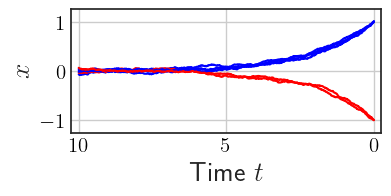

In [111]:
with plt.style.context("seaborn-white"):
    combinations = zip(np.linspace(-0.065,0.065, 6), range(6))

    fig, ax = plt.subplots(figsize=(4, 1.6))

    for init, seed_ in combinations:
        sol = r_process_reverse(init, model_weights_1_step, g, seed_)
        if sol[-1] > 0:
            col = 'blue'
        else:
            col = 'red'
        ax.plot(np.linspace(10.0, 0.0, 1000), sol, color=col)

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'Time $t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)
    
    plt.xlim([10.25, -0.25])
    plt.ylim([-1.25,1.25])
    
    plt.savefig('github/smdp/toy-example/notebooks/pictures/affine_reverse_sde.svg', bbox_inches='tight')

    plt.show()

### 3. Probability Flow ODE

In [112]:
def r_process_reverse_ode(initial_value, params, noise_scaling, seed):
    key = jr.PRNGKey(seed)
    initial_shape = (1,)
    y1 = jnp.ones(shape=initial_shape) * initial_value

    t0, t1 = 0.0, 10.0
    dt0 = 0.01

    def drift(t, y, args):
        return physics_operator(y) - 0.5 * forward_fn(params, key, y, t)
        
    terms = ODETerm(drift)
    solver = Euler()
  
    t0 = jnp.array(0.0)
    
    args = None
    tprev = jnp.array(t1)
    tnext = jnp.array(t1 - dt0)
    y = y1
    
    state = solver.init(terms, tprev, tnext, y1, args)
    
    y_list = []
    
    for i in range(((t1-t0) / dt0).astype(int)):
   
        y, _, _, state, _ = solver.step(terms, tprev, tnext, y, args, state, made_jump=False)
        
        tprev = tnext
     
        tnext = jnp.array(jnp.maximum(tprev - dt0, t0))
    
        y_list.append(y)
    
    return y_list

/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  if jax.tree_structure(self.ω) != jax.tree_structure(other.ω):
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  if jax.tree_structure(self.ω) != jax.tree_structure(other.ω):
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  if jax.tree_structure(self.ω) != jax.tree_structure(other.ω):
/home/benjamin/anaconda3/envs/smdp/lib/python3.8/site-packages/diffrax/misc/omega.py:81: FutureWarning: jax.tree_structure is deprecated, and wil

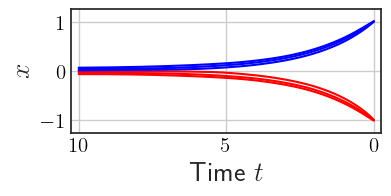

In [113]:
with plt.style.context("seaborn-white"):
    combinations = zip(np.linspace(-0.065,0.065, 6), range(6))

    fig, ax = plt.subplots(figsize=(4, 1.6))

    for init, seed_ in combinations:
        sol = r_process_reverse_ode(init, model_weights_1_step, g, seed_)
        if sol[-1] > 0:
            col = 'blue'
        else:
            col = 'red'
        ax.plot(np.linspace(10.0, 0.0, 1000), sol, color=col)


    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_xlabel(r'Time $t$', size = 20)
    ax.set_ylabel(r'$x$', size = 20)
    ax.grid(True)
    ax.tick_params(labelsize=15)

    plt.xlim([10.25, -0.25])
    plt.ylim([-1.25,1.25])
    
    plt.savefig('github/smdp/toy-example/notebooks/pictures/affine_probability_flow_ode.svg', bbox_inches='tight')
    
    plt.show()